# Loads the processed h5 file and plots data

debugging: the pump probe signal looks weird after implementing mpi

In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [15]:
# input parameters
run_num = 224

# constants
detector_distance = 0.1249 # m
energy = 9.5 # keV

# hit finders parameters
#iq_thr = 0.8 # photon/pix
#iq_thr = 1.1 # photon/pix
iq_thr = 0.4 # photon/pix
r_min, r_max = 200,400 # bins

### load and analyse data

In [16]:
# load data
run = discover_run_h5(run_num, path='/sf/bernina/data/p17743/res/work/hdf5/')[3:-3]
img,Iq,r,nshots,img_hits,thr,nhits,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

# convert q_scale
q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

# convert intensity to photon/pix
#img/=energy
Iq /=energy
i0 /=energy

# normalise to i0
Iq_norm = np.zeros(Iq.shape)
i0_avg = np.average(i0)
norm = i0/i0_avg
for i in range(int(nshots)):
    Iq_norm[i]=Iq[i]/norm[i]
    
# hits
metric,hits = find_hits(Iq_norm,threshold=iq_thr)
hit_rate =len(hits[hits>0])/nshots

# water hits
filter_length = 1
ice_thr = 1.0 # delta photon/pix
q_min, q_max = 1.0,4.5 # A-1
ice_metric, ice_hits = find_ice(Iq_norm[:], q, threshold=ice_thr, 
                                filter_length=filter_length, q_min=q_min, q_max=q_max)

hits *= np.logical_not(ice_hits)
#print(ice_hits)
#print(ice_metric)

# pump probe
hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on)

run0224_droplets_10um_60mm: 17998 shots


<IPython.core.display.Javascript object>


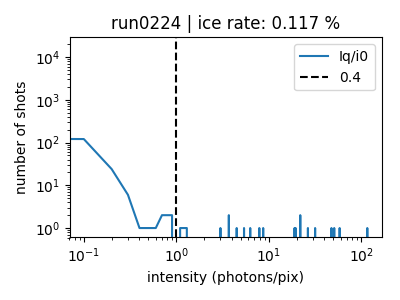

'\nplt.figure()\nplt.plot(ice_hits)\nplt.plot(ice_metric / 10.0)\nplt.show()\nprint(hits)\nprint(ice_hits)\n'

In [17]:
plt.figure(figsize=[4,3])

x,y = do_histogram(ice_metric,0,ice_metric.max(),.1)
plt.plot(x,y)
plt.axvline(x=ice_thr,c='black',ls='--')
plt.legend(['Iq/i0',iq_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix)')
plt.xscale('log',nonposy='clip')
plt.title('run%s | ice rate: %.3f %%'%(run[:4],ice_hits.sum()/nshots*100))
plt.tight_layout()

plt.show()

"""
plt.figure()
plt.plot(ice_hits)
plt.plot(ice_metric / 10.0)
plt.show()
print(hits)
print(ice_hits)
"""

<IPython.core.display.Javascript object>


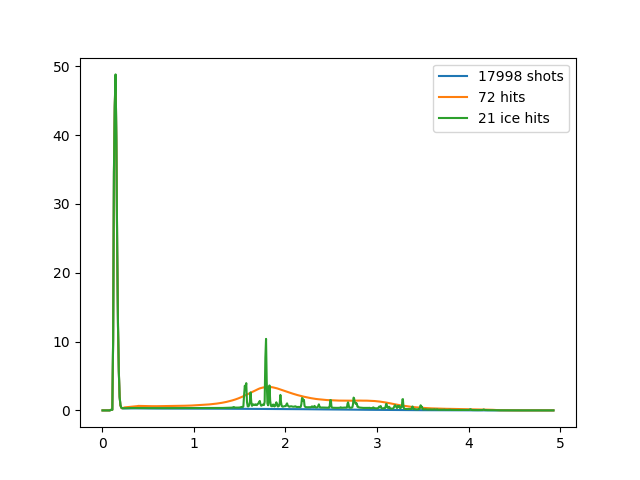

In [18]:
plt.figure()
plt.plot(q,Iq_norm.mean(0),label='%d shots' % nshots)
plt.plot(q,Iq_norm[hits].mean(0),label='%d hits' % hits.sum())
plt.plot(q,Iq_norm[ice_hits].mean(0),label='%d ice hits' % ice_hits.sum())
plt.legend()
plt.show()

### plot

<IPython.core.display.Javascript object>


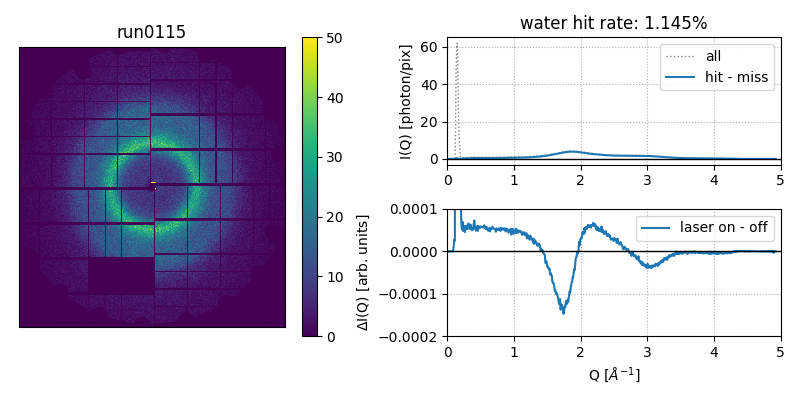

In [6]:
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title('run%s'%run[:4])
#plt.imshow(img/nshots,clim=[0,.6],origin='lower')
#plt.imshow(np.log(img_hits/nhits),clim=[0,5],origin='lower')
plt.imshow(img_hits/nhits,clim=[0,50],origin='lower')
plt.colorbar()
plt.xticks([],'')
plt.yticks([],'')
plt.tight_layout()

plt.subplot(2,2,2)
plt.title('water hit rate: %.3f%%'%(hits.sum()/nshots*1e2))
plt.plot(q, hit_avg,':',c='gray' ,lw=1,label='all')
plt.plot(q, hit_avg - miss_avg, label='hit - miss')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')

ax = plt.subplot(2,2,4)
ax.plot(q, diff_signal, label='laser on - off')
#ax.fill_between(q, -diff_error, diff_error, alpha=0.3)
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-2e-4,1e-4])#plt.figure()
plt.xlabel('Q [$\AA^{-1}$]')
plt.legend()
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=1)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


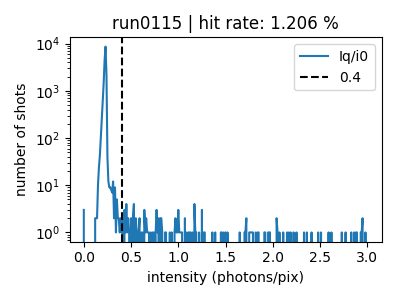

In [7]:
plt.figure(figsize=[4,3])

x,y = do_histogram(metric,0,3,.01)
plt.plot(x,y)
plt.axvline(x=iq_thr,c='black',ls='--')
plt.legend(['Iq/i0',iq_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix)')
plt.title('run%s | hit rate: %.3f %%'%(run[:4],hit_rate*100))
plt.tight_layout()

plt.show()


In [8]:
i0[15]/i0_avg

1.1077131328940124

In [9]:
0.2/i0_avg

0.011767014994698751

In [10]:
hits.sum()/nshots*1e2

1.1445716190687854